In [1]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import FakeCairo #5 qubits
from qiskit.visualization import plot_gate_map, plot_histogram
from qiskit.providers.aer import AerSimulator

import warnings
warnings.filterwarnings('ignore')

from utils.qc_utils import *
import matplotlib.pyplot as plt
from src.IBU import IBU
from utils.data_utils import *

## Simulate Data from 10-qubit GHZ

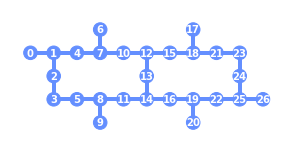

In [2]:
# Select backend and plot gate map
backend = FakeCairo()
sim = AerSimulator.from_backend(backend)
plot_gate_map(backend, plot_directed=True)

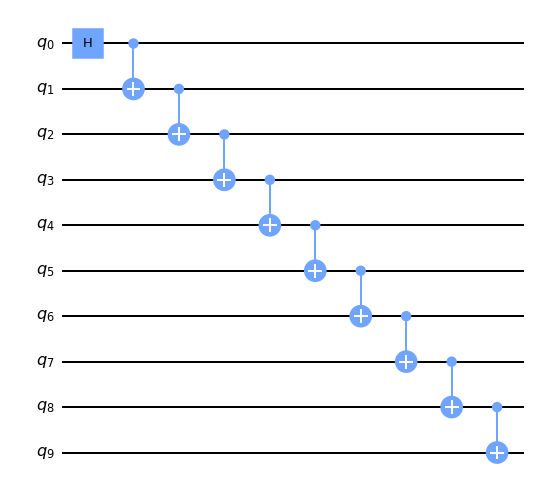

In [3]:
# Construct circuit for 10-qubit GHZ
n = 10
qc = QuantumCircuit(10)
qc.h(0)
for i in range(0,n-1):
    qc.cnot(i,i+1)
qc.draw(fold=-1, output='mpl')

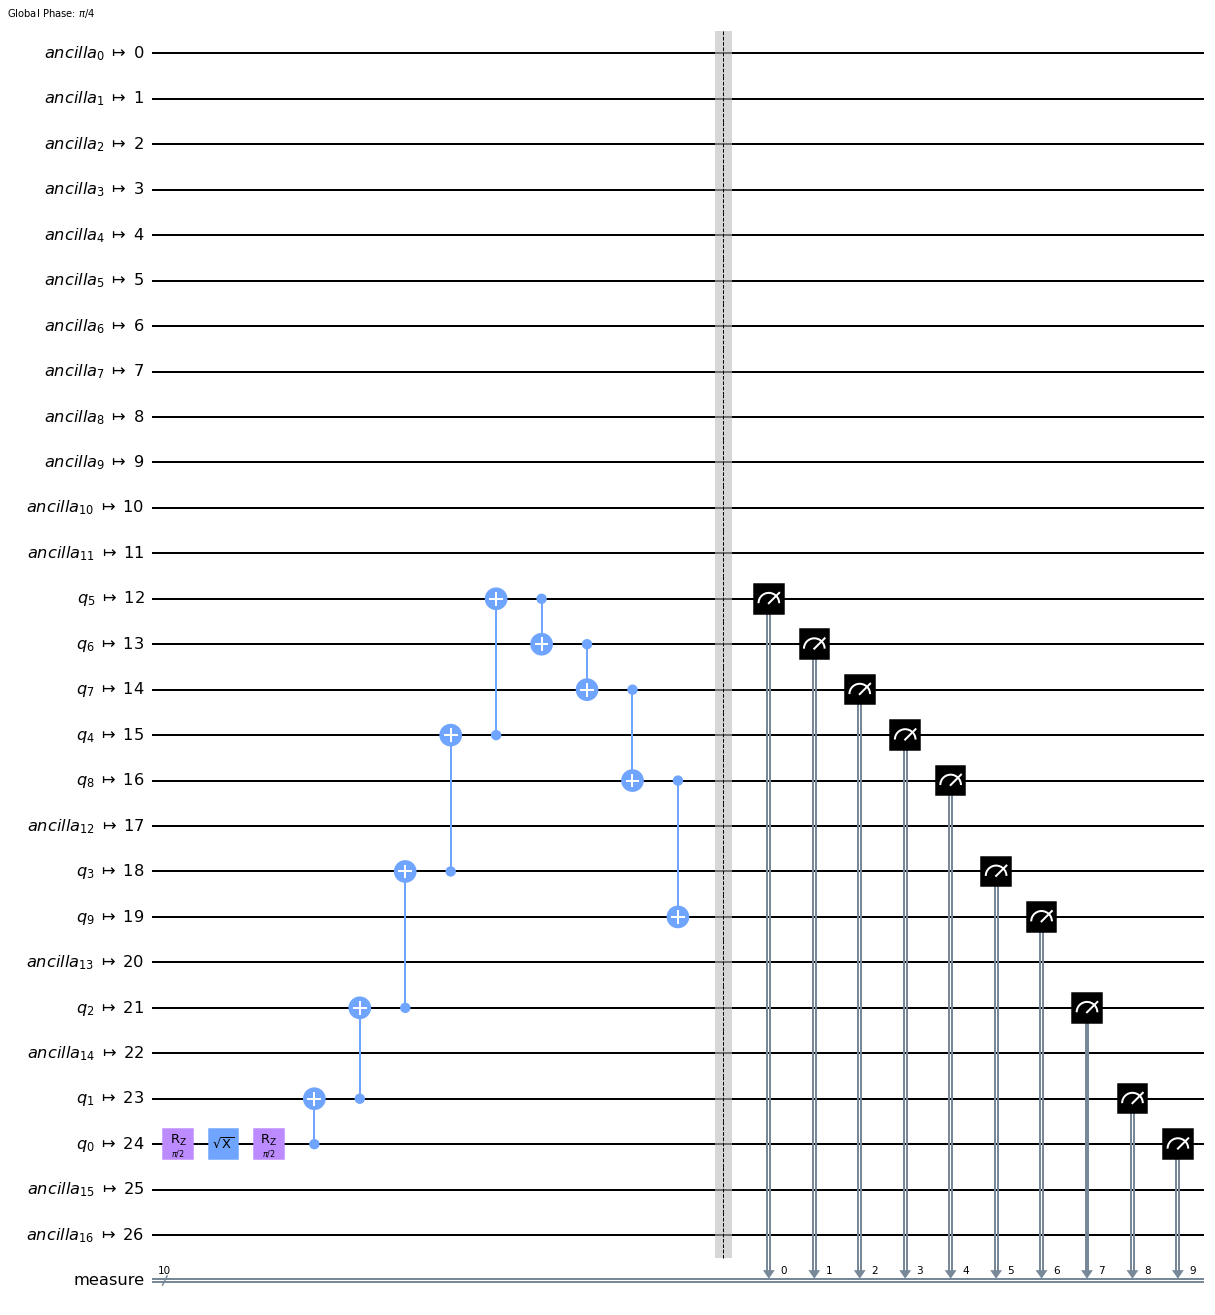

In [4]:
# Make measurements on GHZ state
qc_t = qiskit.transpile(qc, backend=backend)
qc_t.measure_active()
qc_t.draw(fold=-1, output='mpl')

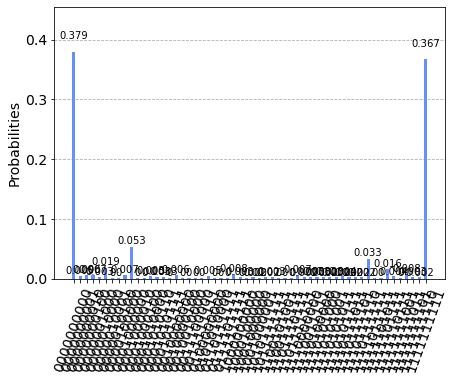

In [5]:
# Run simulator and plot counts
counts = sim.run(qc_t).result().get_counts()
plot_histogram(counts)

In [6]:
# Gather response matrices for each qubit used in GHZ experiment
ac_qubits = get_active_qubits_from_ghz_circuit(qc_t)
matrices = [get_response_matrix(backend, q) for q in ac_qubits]

## Measurement Error Mitigation (Full IBU)

In [7]:
# Settings
params = {
    "exp_name": "ghz",
    "method": "full",  # options: "full", "reduced"
    "library": "jax",  # options: "tensorflow" (for "full" only) or "jax"
    "num_qubits": n,
    "max_iters": 100,
    "tol": 1e-4,
    "use_log": False,  # options: True or False
    "verbose": True,
    "init": "unif",  # options: "unif" or "unif_obs" or "obs"
    "smoothing": 1e-8
}
if params["library"] == 'tensorflow':
    params.update({
        "max_iters": tf.constant(params["max_iters"]),
        "eager_run": True
    })
    tf.config.run_functions_eagerly(params["eager_run"])

Converting dictionary of counts to vector...DONE!
Setting counts distribution...DONE!
Initializing guess with uniform distribution over all bitstrings...DONE!


IBU Iteration:  43%|████▎     | 43/100 [00:00<00:00, 151.08it/s]


Waiting for JAX to return control flow...DONE!



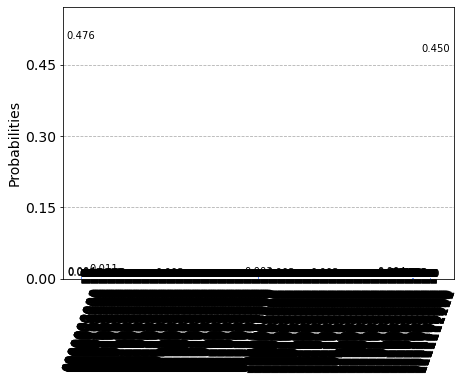

In [8]:
# Run Measurement Error Mitigation with IBU
ibu = IBU(matrices, params)
ibu.set_obs(dict(counts))
ibu.initialize_guess()
t_true_dict = {'0' * n: 0.5, '1' * n: 0.5}
t_sol, max_iters, tracker = ibu.train(params["max_iters"], tol=params["tol"], soln=t_true_dict)
plot_histogram(vec_to_dict(t_sol))

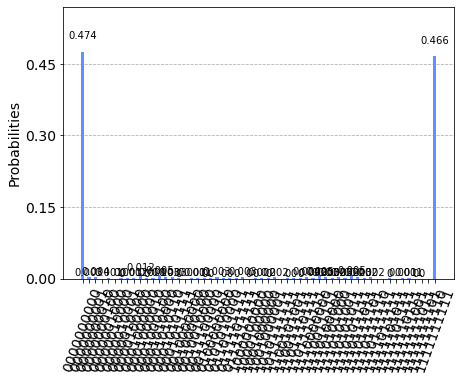

In [9]:
# Run M3 for comparison
import mthree
mit = mthree.M3Mitigation()
mit.cals_from_matrices(matrices)
m3_result = mit.apply_correction(dict(counts), range(len(matrices)), distance=1)
plot_histogram(m3_result)

In [10]:
# Compare IBU vs. M3
ibu_err = tracker[-1]
ibu_neg = float(np.sum(t_sol[t_sol <= 0]))

t_true_dict = {'0' * n: 0.5, '1' * n: 0.5}
m3_err = get_l1_error_between_dicts(t_true_dict, m3_result)
m3_neg = sum([v for k, v in m3_result.items() if v <= 0])

print(f"IBU finished with error of {ibu_err:.5f}, with negative probability totaling {ibu_neg:.5f}; ran for {max_iters} iterations.")

print(f"M3 finished with error of {m3_err:.5f}, with negative probability totaling {m3_neg:.5f}")

IBU finished with error of 0.14851, with negative probability totaling 0.00000; ran for 43 iterations.
M3 finished with error of 0.19586, with negative probability totaling -0.03785


Text(0.5, 1.0, 'log l1 Error of Error Mitigation')

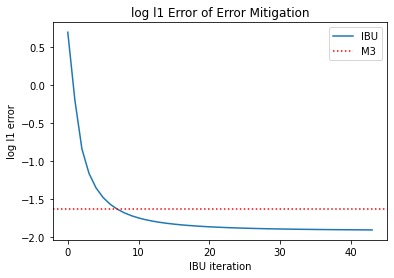

In [11]:
# Plot performance of IBU and M3
plt.plot(np.log(tracker), label='IBU')
plt.axhline(y=np.log(m3_err), color='r', linestyle='dotted', label='M3')
plt.legend(loc="upper right")
plt.xlabel('IBU iteration')
plt.ylabel('log l1 error')
plt.title('log l1 Error of Error Mitigation')

Text(0.5, 1.0, 'Total negative probability')

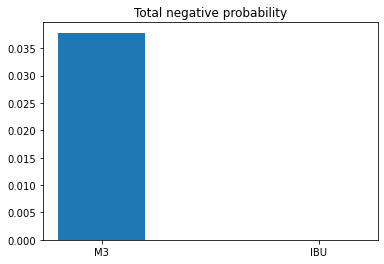

In [12]:
# add negative prob mass plot
plt.bar(['M3','IBU'], [-m3_neg, -ibu_neg], width=0.4)
plt.title('Total negative probability')

## Measurement Error Mitigation (Subspace Reduced IBU)

In [13]:
params = {
    "exp_name": "ghz",
    "method": "reduced",  # options: "full", "reduced"
    "library": "jax",  # options: "tensorflow" (for "full" only) or "jax"
    "num_qubits": n,
    "max_iters": 100,
    "tol": 1e-4,
    "use_log": False,  # options: True or False
    "verbose": True,
    "init": "unif",  # options: "unif" or "unif_obs" or "obs"
    "smoothing": 1e-8,
    "ham_dist": 1
}
if params["library"] == 'tensorflow':
    params.update({
        "max_iters": tf.constant(params["max_iters"]),
        "eager_run": True
    })
    tf.config.run_functions_eagerly(params["eager_run"])

Processing dictionary of counts...


Encoding expanded set of bitstrings as matrix: 100%|██████████| 320/320 [00:00<00:00, 486296.12it/s]


Initializing guess with uniform distribution over the expanded set of bitstrings...DONE!


IBU Iteration:  43%|████▎     | 43/100 [00:00<00:00, 193.91it/s]


Waiting for JAX to return control flow...DONE!



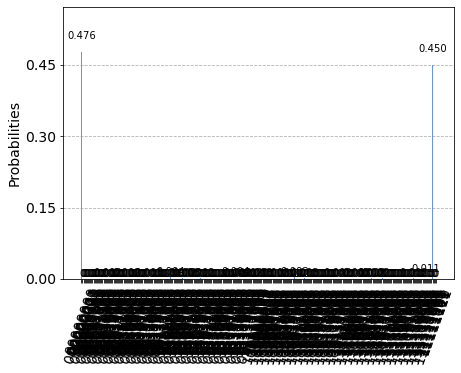

In [14]:
# Run Measurement Error Mitigation with IBU
ibu = IBU(matrices, params)
ibu.set_obs(dict(counts))
ibu.initialize_guess()
t_true_dict = {'0' * n: 0.5, '1' * n: 0.5}
t_sol, max_iters, tracker = ibu.train(params["max_iters"], tol=params["tol"], soln=t_true_dict)
plot_histogram(vec_to_dict(t_sol))

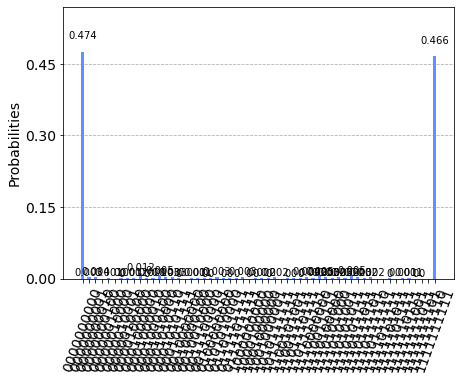

In [15]:
# Run M3 for comparison
import mthree
mit = mthree.M3Mitigation()
mit.cals_from_matrices(matrices)
m3_result = mit.apply_correction(dict(counts), range(len(matrices)), distance=1)
plot_histogram(m3_result)

In [16]:
# Compare IBU vs. M3
ibu_err = tracker[-1]
ibu_neg = float(np.sum(t_sol[t_sol <= 0]))

t_true_dict = {'0' * n: 0.5, '1' * n: 0.5}
m3_err = get_l1_error_between_dicts(t_true_dict, m3_result)
m3_neg = sum([v for k, v in m3_result.items() if v <= 0])

print(f"IBU finished with error of {ibu_err:.5f}, with negative probability totaling {ibu_neg:.5f}; ran for {max_iters} iterations.")

print(f"M3 finished with error of {m3_err:.5f}, with negative probability totaling {m3_neg:.5f}")

IBU finished with error of 0.14851, with negative probability totaling 0.00000; ran for 43 iterations.
M3 finished with error of 0.19586, with negative probability totaling -0.03785


Text(0.5, 1.0, 'log l1 Error of Error Mitigation')

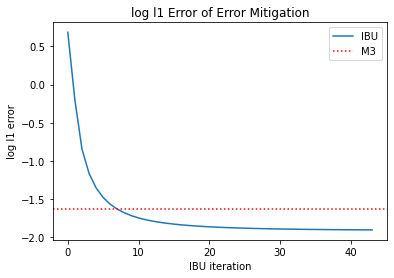

In [17]:
# Plot performance of IBU and M3
plt.plot(np.log(tracker), label='IBU')
plt.axhline(y=np.log(m3_err), color='r', linestyle='dotted', label='M3')
plt.legend(loc="upper right")
plt.xlabel('IBU iteration')
plt.ylabel('log l1 error')
plt.title('log l1 Error of Error Mitigation')

Text(0.5, 1.0, 'Total negative probability')

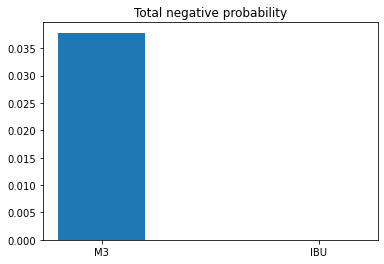

In [18]:
# add negative prob mass plot
plt.bar(['M3','IBU'], [-m3_neg, -ibu_neg], width=0.4)
plt.title('Total negative probability')